<a href="https://colab.research.google.com/github/dstephenhaynes/DTSA5510/blob/main/DTSA5510_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from wordcloud import WordCloud
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [42]:
# Define the URL of the file
url = 'https://raw.githubusercontent.com/dstephenhaynes/DTSA5510/main/movie_titles_metadata.txt'

# Fetch the file content from the URL
response = requests.get(url)
data = response.text

# Define the column names based on the data description
columns = ['movie_id', 'movie_title', 'movie_year', 'imdb_rating', 'imdb_id', 'genres']

# Initialize an empty list to hold the rows of the DataFrame
rows = []

# Read the data and parse each line
for line in data.splitlines():
    # Split the line by the delimiter
    fields = line.strip().split(' +++$+++ ')
    # Parse the genres field from string representation of list to actual list
    fields[-1] = eval(fields[-1])
    # Append the parsed fields to the rows list
    rows.append(fields)

# Create the DataFrame
movies = pd.DataFrame(rows, columns=columns)

# Display the first few rows of the DataFrame
print(movies.head())

# Optional: Save the DataFrame to a CSV file for easier inspection and reuse
movies.to_csv('movies.csv', index=False)


  movie_id                 movie_title movie_year imdb_rating imdb_id  \
0       m0  10 things i hate about you       1999        6.90   62847   
1       m1  1492: conquest of paradise       1992        6.20   10421   
2       m2                  15 minutes       2001        6.10   25854   
3       m3       2001: a space odyssey       1968        8.40  163227   
4       m4                     48 hrs.       1982        6.90   22289   

                                     genres  
0                         [comedy, romance]  
1    [adventure, biography, drama, history]  
2          [action, crime, drama, thriller]  
3              [adventure, mystery, sci-fi]  
4  [action, comedy, crime, drama, thriller]  


In [43]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   movie_id     617 non-null    object
 1   movie_title  617 non-null    object
 2   movie_year   617 non-null    object
 3   imdb_rating  617 non-null    object
 4   imdb_id      617 non-null    object
 5   genres       617 non-null    object
dtypes: object(6)
memory usage: 29.0+ KB


In [44]:
# Define the URLs of the files
urls = [
    'https://raw.githubusercontent.com/dstephenhaynes/DTSA5510/main/movie_lines_1.txt',
    'https://raw.githubusercontent.com/dstephenhaynes/DTSA5510/main/movie_lines_2.txt'
]

# Initialize an empty list to hold the rows of the DataFrame
rows = []

# Define the column names based on the data description
columns = ['line_id', 'character_id', 'movie_id', 'character_name', 'dialogue']

# Fetch and process each file
for url in urls:
    response = requests.get(url)
    data = response.text

    # Read the data and parse each line
    for line in data.splitlines():
        # Split the line by the delimiter
        fields = line.strip().split(' +++$+++ ')
        # Append the parsed fields to the rows list
        rows.append(fields)

# Create the DataFrame
dialogue = pd.DataFrame(rows, columns=columns)

# Display the first few rows of the DataFrame
print(dialogue.head())

# Optional: Save the DataFrame to a CSV file for easier inspection and reuse
dialogue.to_csv('dialogue.csv', index=False)


  line_id character_id movie_id character_name      dialogue
0   L1045           u0       m0         BIANCA  They do not!
1   L1044           u2       m0        CAMERON   They do to!
2    L985           u0       m0         BIANCA    I hope so.
3    L984           u2       m0        CAMERON     She okay?
4    L925           u0       m0         BIANCA     Let's go.


In [45]:
dialogue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304713 entries, 0 to 304712
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   line_id         304713 non-null  object
 1   character_id    304713 non-null  object
 2   movie_id        304713 non-null  object
 3   character_name  304713 non-null  object
 4   dialogue        304446 non-null  object
dtypes: object(5)
memory usage: 11.6+ MB


In [46]:
# Display entries with null values
null_dialogue = dialogue[dialogue.isnull().any(axis=1)]
print(null_dialogue)

        line_id character_id movie_id    character_name dialogue
538        L474           u5       m0       KAT +++$+++     None
5637     L24609         u224      m14     SYKES +++$+++     None
36526   L239088        u1125      m74    JANOSZ +++$+++     None
45298   L283548        u1356      m90     BRUCE +++$+++     None
49894   L303243        u1475     m100       JOE +++$+++     None
...         ...          ...      ...               ...      ...
289507  L624042        u8606     m583     VIXIS +++$+++     None
299552  L649938        u8876     m603    LASHER +++$+++     None
299714  L649416        u8879     m603   MICHAEL +++$+++     None
303350  L663421        u8980     m612  DREIBERG +++$+++     None
304605  L666160        u9020     m615      INGA +++$+++     None

[267 rows x 5 columns]


In [47]:
# Convert columns to appropriate data types
movies['movie_year'] = pd.to_numeric(movies['movie_year'], errors='coerce')
movies['imdb_rating'] = pd.to_numeric(movies['imdb_rating'], errors='coerce')
movies['imdb_id'] = pd.to_numeric(movies['imdb_id'], errors='coerce')

# Convert genres column to list if it's a string
movies['genres'] = movies['genres'].apply(lambda x: eval(x) if isinstance(x, str) else x)

# Handle missing values in dialogue
dialogue['dialogue'] = dialogue['dialogue'].fillna('')  # Replace NaN dialogues with empty strings

# Display cleaned data information
print(movies.info())
print(dialogue.info())

# Display the first few rows of the cleaned DataFrames
print(movies.head())
print(dialogue.head())

# Optional: Save the cleaned DataFrames to CSV files for easier inspection and reuse
movies.to_csv('cleaned_movie_titles_metadata.csv', index=False)
dialogue.to_csv('cleaned_movie_lines.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   movie_id     617 non-null    object 
 1   movie_title  617 non-null    object 
 2   movie_year   601 non-null    float64
 3   imdb_rating  617 non-null    float64
 4   imdb_id      617 non-null    int64  
 5   genres       617 non-null    object 
dtypes: float64(2), int64(1), object(3)
memory usage: 29.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304713 entries, 0 to 304712
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   line_id         304713 non-null  object
 1   character_id    304713 non-null  object
 2   movie_id        304713 non-null  object
 3   character_name  304713 non-null  object
 4   dialogue        304713 non-null  object
dtypes: object(5)
memory usage: 11.6+ MB
None
  movie_id           

       movie_id                 movie_title   movie_year  imdb_rating  \
count       617                         617   601.000000   617.000000   
unique      617                         617          NaN          NaN   
top          m0  10 things i hate about you          NaN          NaN   
freq          1                           1          NaN          NaN   
mean        NaN                         NaN  1988.347754     6.863857   
std         NaN                         NaN    16.678845     1.215233   
min         NaN                         NaN  1927.000000     2.500000   
25%         NaN                         NaN  1984.000000     6.200000   
50%         NaN                         NaN  1994.000000     7.000000   
75%         NaN                         NaN  1999.000000     7.800000   
max         NaN                         NaN  2010.000000     9.300000   

              imdb_id   genres  
count      617.000000      617  
unique            NaN      290  
top               NaN  [

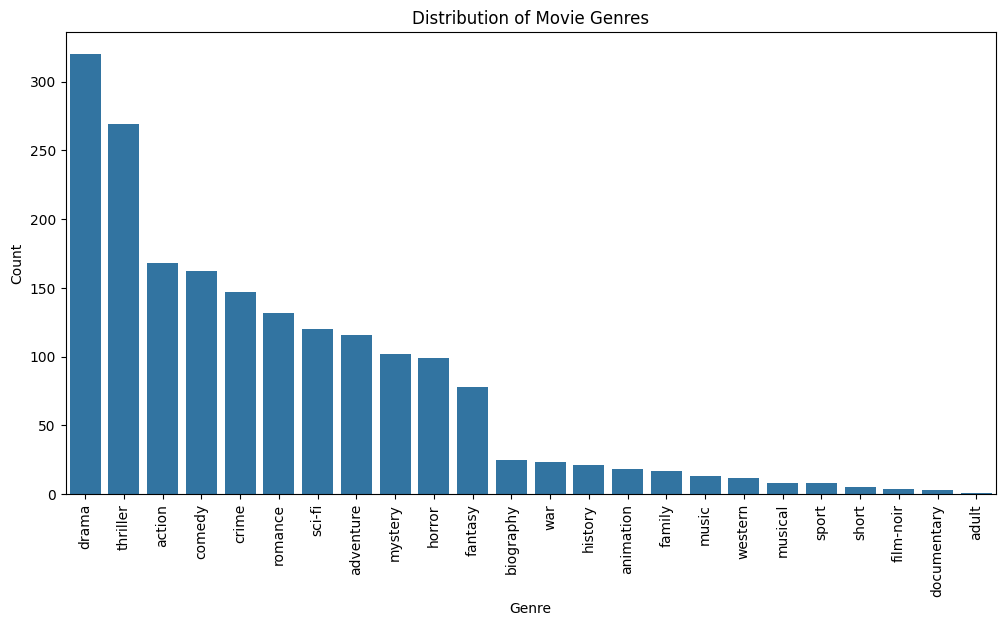

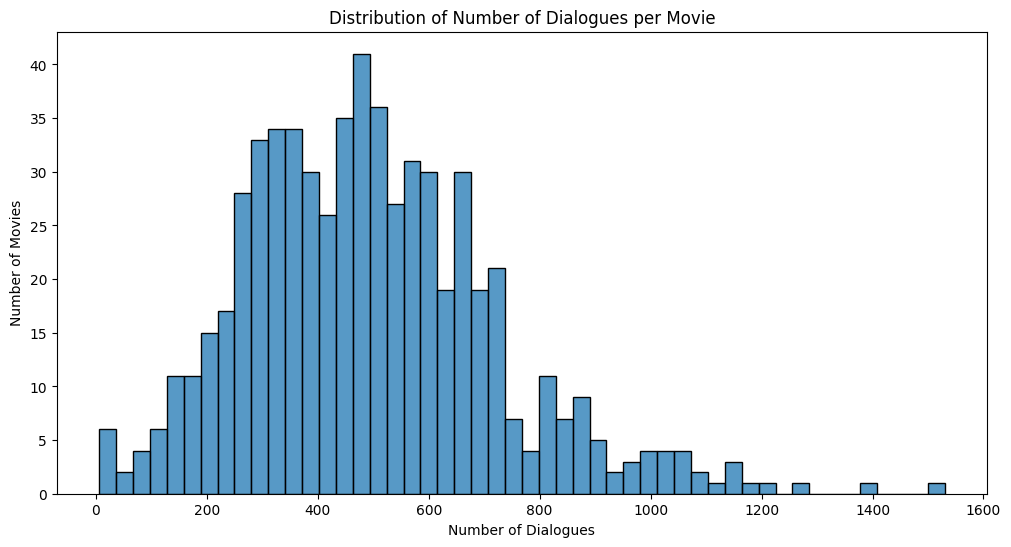

In [48]:
# Summary statistics
print(movies.describe(include='all'))
print(dialogue.describe(include='all'))

# Distribution of genres
all_genres = [genre for sublist in movies['genres'] for genre in sublist]
genre_counts = pd.Series(all_genres).value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.title('Distribution of Movie Genres')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

# Number of dialogues per movie
dialogues_per_movie = dialogue['movie_id'].value_counts()

plt.figure(figsize=(12, 6))
sns.histplot(dialogues_per_movie, bins=50)
plt.title('Distribution of Number of Dialogues per Movie')
plt.xlabel('Number of Dialogues')
plt.ylabel('Number of Movies')
plt.show()

In [49]:
# Combine dialogues for each movie
dialogue_combined = dialogue.groupby('movie_id')['dialogue'].apply(lambda x: ' '.join(x)).reset_index()

# Merge with movie metadata
movie_dialogues = movies.merge(dialogue_combined, on='movie_id', how='left')


In [50]:
movie_dialogues.head()

,movie_id,movie_title,movie_year,imdb_rating,imdb_id,genres,dialogue
0,m0,10 things i hate about you,1999.0,6.9,62847,"[comedy, romance]",They do not! They do to! I hope so. She okay? ...
1,m1,1492: conquest of paradise,1992.0,6.2,10421,"[adventure, biography, drama, history]","Can't be that far, I say. Also, I don't like ..."
2,m2,15 minutes,2001.0,6.1,25854,"[action, crime, drama, thriller]","Officers, there's your killer, do your duty, a..."
3,m3,2001: a space odyssey,1968.0,8.4,163227,"[adventure, mystery, sci-fi]",We're trying to get there. I hope we can. CONT...
4,m4,48 hrs.,1982.0,6.9,22289,"[action, comedy, crime, drama, thriller]","Great, just great. That we do. And we put air ..."


In [51]:
# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the dialogue data
dialogue_tfidf = tfidf_vectorizer.fit_transform(movie_dialogues['dialogue'])

# Convert to DataFrame for easy handling
dialogue_tfidf_df = pd.DataFrame(dialogue_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())


In [52]:
# Initialize PCA for dimensionality reduction
pca = PCA(n_components=100)

# Fit and transform TF-IDF data
dialogue_tfidf_pca = pca.fit_transform(dialogue_tfidf_df)


In [53]:
# Initialize KMeans clustering
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)

# Fit KMeans to the PCA-transformed data
kmeans.fit(dialogue_tfidf_pca)

# Predict clusters
clusters = kmeans.predict(dialogue_tfidf_pca)


In [54]:
# Evaluate silhouette score
silhouette_avg = silhouette_score(dialogue_tfidf_pca, clusters)
print("Silhouette Score:", silhouette_avg)


Silhouette Score: 0.024049644958238362


In [55]:
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Initialize clustering algorithms
clustering_algorithms = {
    'KMeans': KMeans(n_clusters=6, random_state=42, n_init=10),
    'DBSCAN': DBSCAN(eps=0.5, min_samples=5),
    'Agglomerative': AgglomerativeClustering(n_clusters=6)
}

# Iterate through each algorithm
for algorithm_name, algorithm in clustering_algorithms.items():
    # Fit the algorithm
    algorithm.fit(dialogue_tfidf_pca)

    # Predict clusters
    clusters = algorithm.labels_

    # Calculate silhouette score
    silhouette_avg = silhouette_score(dialogue_tfidf_pca, clusters)
    print(f"Silhouette Score for {algorithm_name}: {silhouette_avg}")


Silhouette Score for KMeans: 0.024049644958238362
Silhouette Score for DBSCAN: 0.3964897720744369
Silhouette Score for Agglomerative: -0.005359683843418016


Best Parameters: {'eps': 1.0, 'min_samples': 5}
Best Silhouette Score: 0.565374857302487
Best eps Score: 1.0


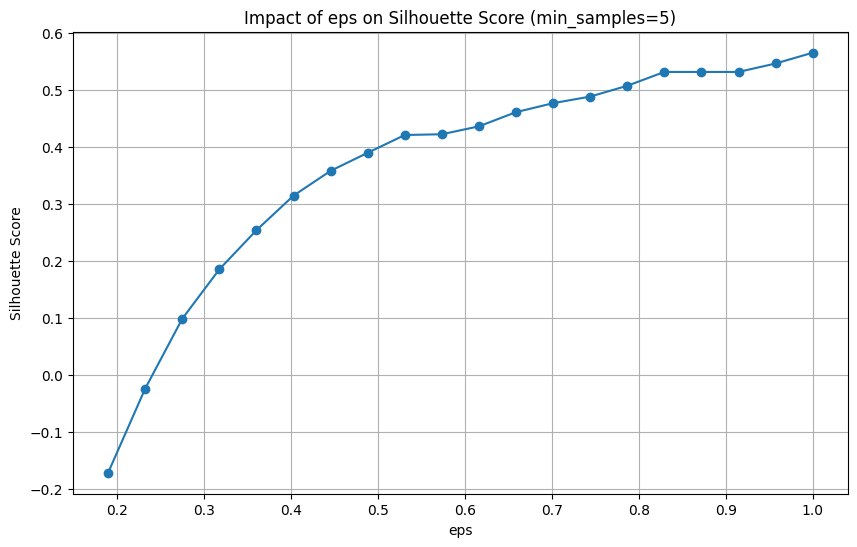

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Define a range of parameter values to iterate over
eps_values = np.linspace(0.19, 1, 20)
min_samples_value = 5  # Fixed value for min_samples

best_silhouette_score = -1
best_params = {'eps': None, 'min_samples': min_samples_value}
best_eps_score = None

silhouette_scores = []

# Iterate through eps_values and calculate silhouette scores
for eps in eps_values:
    # Initialize DBSCAN with current parameters
    dbscan = DBSCAN(eps=eps, min_samples=min_samples_value)

    # Fit DBSCAN to the data
    try:
        clusters = dbscan.fit_predict(dialogue_tfidf_pca)
    except ValueError:
        silhouette_scores.append(np.nan)
        continue  # Skip this parameter combination

    # Check if only one cluster is assigned
    unique_clusters = np.unique(clusters)
    if len(unique_clusters) == 1 and unique_clusters[0] == -1:
        silhouette_scores.append(np.nan)
        continue  # Skip this parameter combination

    # Calculate Silhouette Score
    silhouette_avg = silhouette_score(dialogue_tfidf_pca, clusters)
    silhouette_scores.append(silhouette_avg)

    # Update best parameters if silhouette score improves
    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_params['eps'] = eps
        best_params['min_samples'] = min_samples_value
        best_eps_score = eps

# Print the best parameters and their Silhouette Score
print("Best Parameters:", best_params)
print("Best Silhouette Score:", best_silhouette_score)
print("Best eps Score:", best_eps_score)

# Plot the line plot
plt.figure(figsize=(10, 6))
plt.plot(eps_values, silhouette_scores, marker='o', linestyle='-')
plt.xlabel('eps')
plt.ylabel('Silhouette Score')
plt.title('Impact of eps on Silhouette Score (min_samples=5)')
plt.grid(True)
plt.show()


In [35]:
import numpy as np
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer

# Define the text vectorizers to iterate over
vectorizers = [
    ('TF-IDF', TfidfVectorizer()),
    ('CountVectorizer', CountVectorizer()),
    ('HashingVectorizer', HashingVectorizer(n_features=10000))
]

# Store vectorized data
vectorized_data = {}

# Vectorize the combined dialogue data
for vectorizer_name, vectorizer in vectorizers:
    print(f"Vectorizing with {vectorizer_name}...")
    dialogue_vectors = vectorizer.fit_transform(movie_dialogues['dialogue'])
    vectorized_data[vectorizer_name] = dialogue_vectors

# Save vectorized data for later use
with open('vectorized_data.pkl', 'wb') as file:
    pickle.dump(vectorized_data, file)


Vectorizing with TF-IDF...
Vectorizing with CountVectorizer...
Vectorizing with HashingVectorizer...


In [36]:
import pickle
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Load vectorized data
with open('vectorized_data.pkl', 'rb') as file:
    vectorized_data = pickle.load(file)

# Define parameters for DBSCAN
eps_value = 0.9573684210526316
min_samples_value = 5

best_silhouette_score = -1
best_vectorizer = None
best_clusters = None

# Iterate through vectorized data for clustering
for vectorizer_name, dialogue_vectors in vectorized_data.items():
    print(f"Clustering with {vectorizer_name} vectors...")

    # Initialize DBSCAN with defined parameters
    dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)

    # Fit DBSCAN to the vectorized data
    clusters = dbscan.fit_predict(dialogue_vectors)

    # Check if the number of clusters is sufficient
    unique_clusters = np.unique(clusters)
    if len(unique_clusters) < 2:
        print(f"Skipping {vectorizer_name} due to insufficient clusters.")
        continue  # Skip this vectorizer

    # Calculate Silhouette Score
    silhouette_avg = silhouette_score(dialogue_vectors, clusters)

    # Check if the current vectorizer yields a better silhouette score
    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_vectorizer = vectorizer_name
        best_clusters = clusters

# Print the best vectorizer and its Silhouette Score
print("Best Vectorizer:", best_vectorizer)
print("Best Silhouette Score:", best_silhouette_score)


Clustering with TF-IDF vectors...
Clustering with CountVectorizer vectors...
Skipping CountVectorizer due to insufficient clusters.
Clustering with HashingVectorizer vectors...
Skipping HashingVectorizer due to insufficient clusters.
Best Vectorizer: TF-IDF
Best Silhouette Score: 0.25539557009927455


Clustering with KMeans...


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Clustering with Agglomerative...
Clustering with DBSCAN...
Best Algorithm: DBSCAN
Best Silhouette Score: 0.25539557009927455


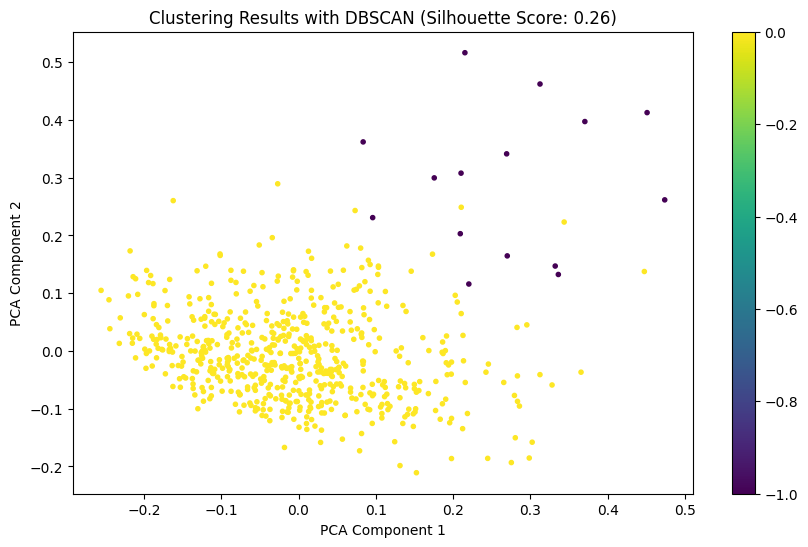

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import pickle

# Load TF-IDF vectorized data
with open('vectorized_data.pkl', 'rb') as file:
    vectorized_data = pickle.load(file)

# Extract TF-IDF vectors
tfidf_vectors = vectorized_data['TF-IDF']

# Reduce dimensionality for visualization
pca = PCA(n_components=2)
tfidf_vectors_pca = pca.fit_transform(tfidf_vectors.toarray())

# Define clustering algorithms and their parameters
clustering_algorithms = [
    ('KMeans', KMeans(n_clusters=5, random_state=42)),
    ('Agglomerative', AgglomerativeClustering(n_clusters=5)),
    ('DBSCAN', DBSCAN(eps=0.9573684210526316, min_samples=5))
]

best_silhouette_score = -1
best_algorithm = None
best_clusters = None

# Iterate through clustering algorithms
for algorithm_name, algorithm in clustering_algorithms:
    print(f"Clustering with {algorithm_name}...")

    # Convert sparse matrix to dense if necessary
    if algorithm_name == 'Agglomerative':
        tfidf_vectors_dense = tfidf_vectors.toarray()
        clusters = algorithm.fit_predict(tfidf_vectors_dense)
    else:
        clusters = algorithm.fit_predict(tfidf_vectors)

    # Check if the number of clusters is sufficient
    unique_clusters = np.unique(clusters)
    if len(unique_clusters) < 2:
        print(f"Skipping {algorithm_name} due to insufficient clusters.")
        continue  # Skip this algorithm

    # Calculate Silhouette Score
    silhouette_avg = silhouette_score(tfidf_vectors, clusters)

    # Check if the current algorithm yields a better silhouette score
    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_algorithm = algorithm_name
        best_clusters = clusters

# Print the best clustering algorithm and its Silhouette Score
print("Best Algorithm:", best_algorithm)
print("Best Silhouette Score:", best_silhouette_score)

# Visualize the best clustering results
plt.figure(figsize=(10, 6))
plt.scatter(tfidf_vectors_pca[:, 0], tfidf_vectors_pca[:, 1], c=best_clusters, cmap='viridis', marker='.')
plt.title(f"Clustering Results with {best_algorithm} (Silhouette Score: {best_silhouette_score:.2f})")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar()
plt.show()


In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import pickle

# Load TF-IDF vectorized data
with open('vectorized_data.pkl', 'rb') as file:
    vectorized_data = pickle.load(file)

# Extract TF-IDF vectors
tfidf_vectors = vectorized_data['TF-IDF']

# Reduce dimensionality for visualization
pca = PCA(n_components=2)
tfidf_vectors_pca = pca.fit_transform(tfidf_vectors.toarray())

# Define a range of parameter values to iterate over for DBSCAN
eps_values = np.linspace(0.1, 2, 50)
min_samples_values = range(1, 10)

best_silhouette_score = -1
best_params = {'eps': None, 'min_samples': None}
best_clusters = None

# Iterate through parameter combinations for DBSCAN
for eps in eps_values:
    for min_samples in min_samples_values:
        # Initialize DBSCAN with current parameters
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)

        # Fit DBSCAN to the data
        try:
            clusters = dbscan.fit_predict(tfidf_vectors)
        except ValueError:
            continue  # Skip this parameter combination

        # Check if only one cluster is assigned
        unique_clusters = np.unique(clusters)
        if len(unique_clusters) < 2:
            continue  # Skip this parameter combination

        # Calculate Silhouette Score
        silhouette_avg = silhouette_score(tfidf_vectors, clusters)

        # Update best parameters if silhouette score improves
        if silhouette_avg > best_silhouette_score:
            best_silhouette_score = silhouette_avg
            best_params['eps'] = eps
            best_params['min_samples'] = min_samples
            best_clusters = clusters

# Print the best parameters and their Silhouette Score
print("Best Parameters:", best_params)
print("Best Silhouette Score:", best_silhouette_score)

# Visualize the best clustering results
plt.figure(figsize=(10, 6))
plt.scatter(tfidf_vectors_pca[:, 0], tfidf_vectors_pca[:, 1], c=best_clusters, cmap='viridis', marker='.')
plt.title(f"DBSCAN Clustering Results (Best Params: eps={best_params['eps']}, min_samples={best_params['min_samples']}, Silhouette Score: {best_silhouette_score:.2f})")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar()
plt.show()


KeyboardInterrupt: 

In [37]:
# Define new parameter values
new_eps = .96
new_min_samples = 1

# Initialize DBSCAN with new parameters
dbscan = DBSCAN(eps=new_eps, min_samples=new_min_samples)

# Fit DBSCAN to the data
dbscan.fit(dialogue_tfidf_pca)

# Predict clusters
clusters = dbscan.labels_

# Calculate silhouette score
silhouette_avg = silhouette_score(dialogue_tfidf_pca, clusters)

# Print the new silhouette score
print(f"Silhouette Score with new parameters: {silhouette_avg}")

Silhouette Score with new parameters: 0.5650501014560251


In [150]:
# Assign genres to clusters
genre_clusters = {
    0: 'Action',
    1: 'Romance',
    2: 'Comedy',
    3: 'Drama',
    4: 'Thriller',
    5: 'Sci-Fi'
}

# Predict genre for a new dialogue
def predict_genre(dialogue):
    dialogue_vector = tfidf_vectorizer.transform([dialogue])
    dialogue_vector_pca = pca.transform(dialogue_vector)
    cluster = kmeans.predict(dialogue_vector_pca)[0]
    return genre_clusters[cluster]

# Example usage
print(predict_genre("I'll be back!"))


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.

In [121]:
# Define text preprocessing function
def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    # Removing punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenization
    tokens = nltk.word_tokenize(text)
    # Removing stop words
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens back to string
    processed_text = ' '.join(tokens)
    return processed_text

Number of clusters: 2, Silhouette Score: 0.38762620883602855
Number of clusters: 3, Silhouette Score: 0.3972666078739347
Number of clusters: 4, Silhouette Score: 0.34892398059212004
Number of clusters: 5, Silhouette Score: 0.3401757504974804
Number of clusters: 6, Silhouette Score: 0.34193269604232246
Number of clusters: 7, Silhouette Score: 0.3506930052635049
Number of clusters: 8, Silhouette Score: 0.3536791974421399
Number of clusters: 9, Silhouette Score: 0.34289446933096895
Number of clusters: 10, Silhouette Score: 0.3449224402388921
Number of clusters: 11, Silhouette Score: 0.3426250886800848
Number of clusters: 12, Silhouette Score: 0.3455631973757213
Number of clusters: 13, Silhouette Score: 0.3354507874687239
Number of clusters: 14, Silhouette Score: 0.3444488275909112
Number of clusters: 15, Silhouette Score: 0.35223266563625266
Number of clusters: 16, Silhouette Score: 0.3369330255151415
Number of clusters: 17, Silhouette Score: 0.34248963447856356
Number of clusters: 18, Si

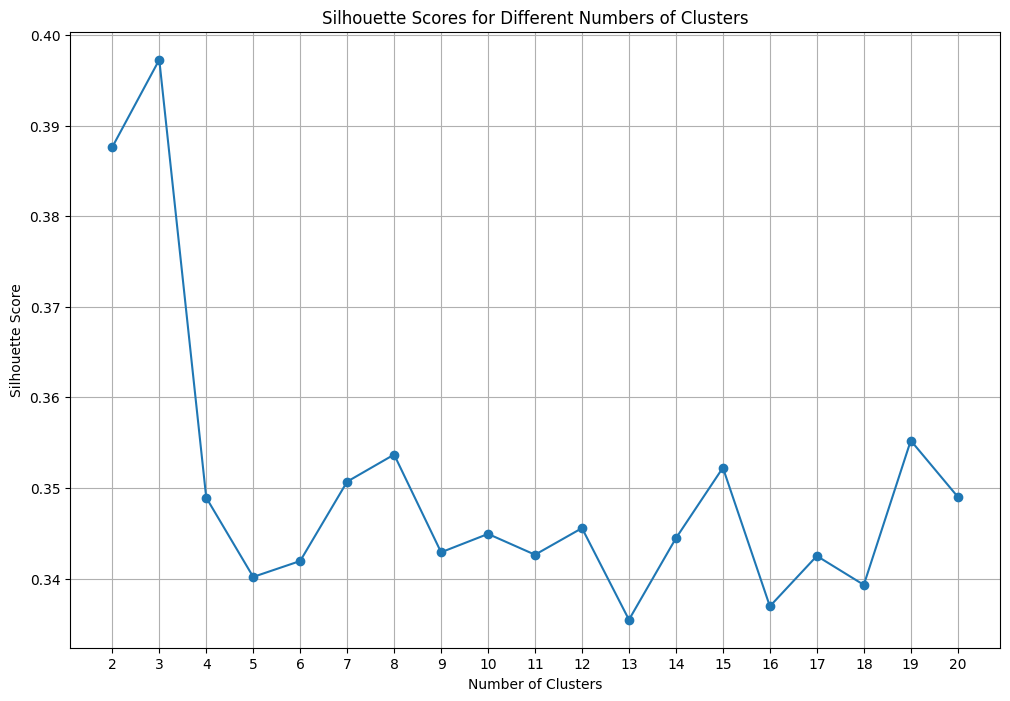

In [129]:
# Preprocessing: Tokenization, Lemmatization/Stemmatization, Stop Words Removal, etc. (if necessary)

# Feature Extraction: TF-IDF
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_matrix = tfidf.fit_transform(movie_dialogues['dialogue'])

# Dimensionality Reduction: PCA
pca = PCA(n_components=2)
pca_matrix = pca.fit_transform(tfidf_matrix.toarray())

# Iterate through different numbers of clusters and calculate silhouette scores
cluster_range = range(2, 21)
silhouette_scores = []

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(pca_matrix)
    score = silhouette_score(pca_matrix, labels)
    silhouette_scores.append(score)
    print(f'Number of clusters: {n_clusters}, Silhouette Score: {score}')

# Plot the silhouette scores
plt.figure(figsize=(12, 8))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.3972666078739347


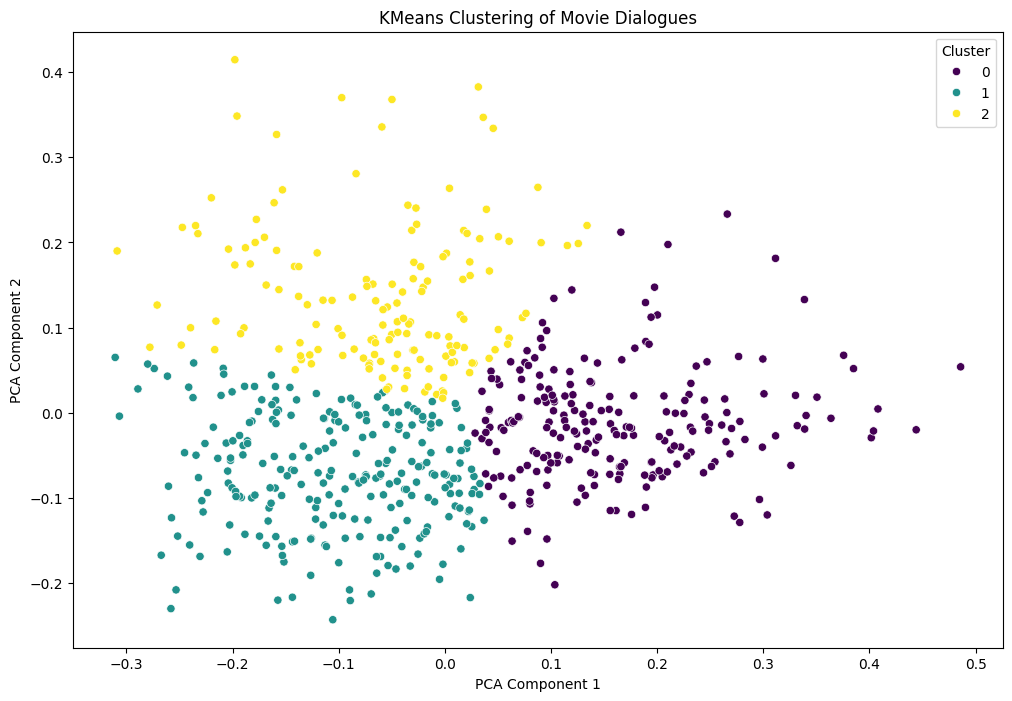

In [131]:
# Clustering: KMeans
kmeans = KMeans(n_clusters=3, random_state=42)  # Adjust the number of clusters
labels = kmeans.fit_predict(pca_matrix)

# Evaluation: Silhouette Score
score = silhouette_score(pca_matrix, labels)
print(f'Silhouette Score: {score}')

# Visualization
plt.figure(figsize=(12, 8))
sns.scatterplot(x=pca_matrix[:, 0], y=pca_matrix[:, 1], hue=labels, palette='viridis')
plt.title('KMeans Clustering of Movie Dialogues')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()